In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch
import random
from IPython.display import clear_output

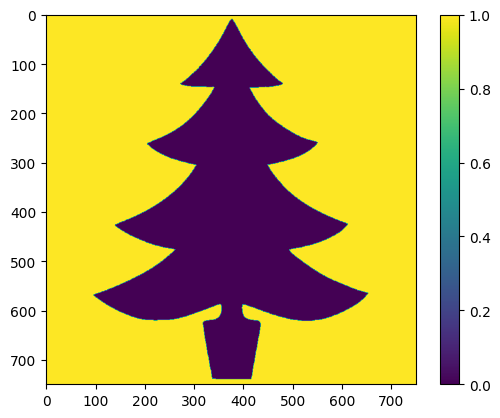

In [2]:
import skimage.data
img = skimage.data.horse()

import imageio.v2 as imageio
img = imageio.imread('tree.png')[:, :, 2] > 200

plt.colorbar(plt.imshow(img))

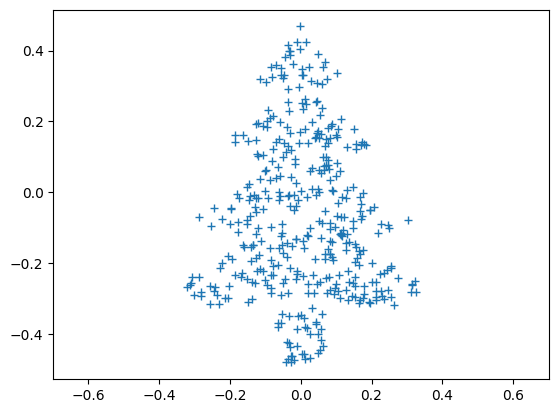

In [6]:
def sample_target():
    target = []
    while len(target) < 400:
        x = random.randrange(img.shape[0])
        y = random.randrange(img.shape[1])
        pt = img[x, y]
        if not pt:
            target.append([y / img.shape[1] - 0.5, 1 - x / img.shape[0] - 0.5])
    target = torch.tensor(target)
    return target

plt.axis('equal')
T = sample_target()
plt.plot(T[:, 0], T[:, 1], '+')

In [4]:
def random_affine():
    return torch.cat([
        torch.rand(2) * torch.tensor([np.pi * 2, 1]),
        torch.randn(2) / 2
    ]) # rotate, scale, dx, dy

def affine_to_matrix(a):
    out = torch.zeros(3, 3)
    out[0, 0] = a[1] * a[0].cos()
    out[0, 1] = a[1] * -a[0].sin()
    out[1, 0] = a[1] * a[0].sin()
    out[1, 1] = a[1] * a[0].cos()
    out[0, 2] = a[2]
    out[1, 2] = a[3]
    out[2, 2] = 1.
    return out

def chamfer(A, B): # A = target, B = trace
    assert A.shape[1] == 2
    assert B.shape[1] == 2
    
    dists = ((A.unsqueeze(0) - B.unsqueeze(1)) ** 2).sum(dim=2)
    
    mins_a = torch.min(dists, dim=0).values
    mins_b = torch.min(dists, dim=1).values
    return mins_a.mean() + mins_b.mean()

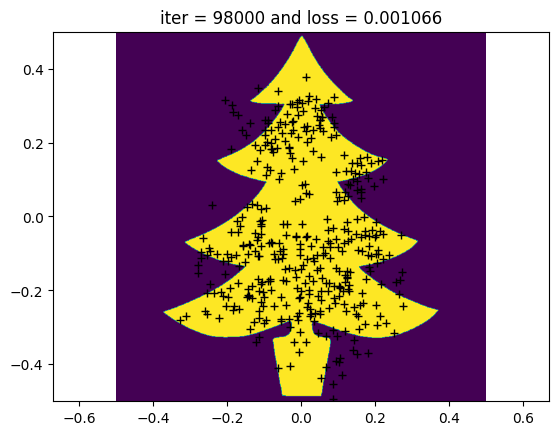

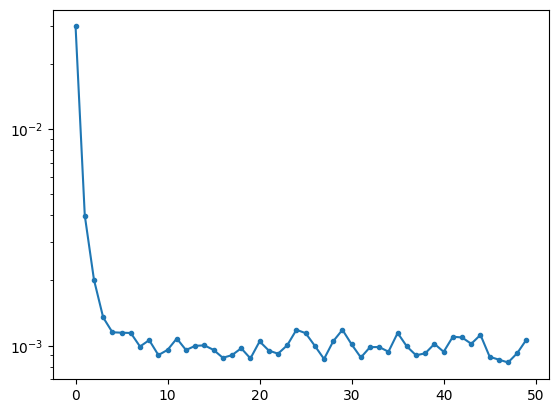

In [8]:
N = 3
F_ = [random_affine() for i in range(N)]

for f in F_:
    f.requires_grad_()
o = torch.optim.Adam(F_, lr=0.0001)


import os
os.system('rm out/*.jpg')

losses = []

for step in range(100_000):
    o.zero_grad()
    
    v = torch.tensor([0., 0., 1.])
    trace = []
    
    F = [affine_to_matrix(a) for a in F_]
    fate = [random.randrange(len(F)) for _ in range(400)]
    for f in fate:
        v = torch.matmul(F[f], v)
        trace.append(v)

    trace = torch.stack(trace)[:, :2]
    
    loss = chamfer(sample_target(), trace)
    loss.backward()
    o.step()
    
    if step % 2_000 == 0:
        losses.append(loss.detach().item())
        
        clear_output(wait=True)
        trace_ = trace.detach().numpy()
        plt.title('iter = %d and loss = %f' % (step, loss.detach().item()))
        plt.axis('equal')
        plt.imshow(~img, extent=(-0.5, 0.5, -0.5, 0.5))
        plt.plot(trace_[:, 0], trace_[:, 1], 'k+')
        plt.savefig('out/%010d.jpg' % step)
        plt.show()
        
plt.figure()
plt.plot(losses, '.-')
plt.yscale('log')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

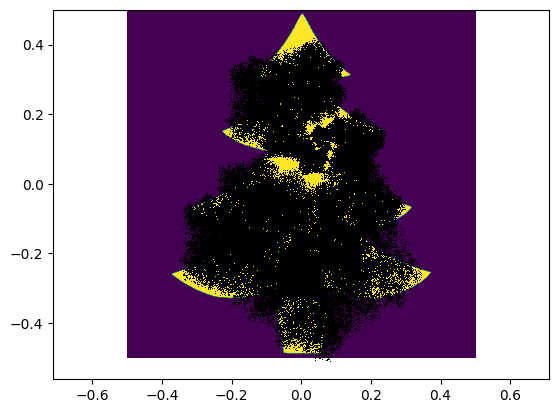

In [11]:
plt.axis('equal')
plt.imshow(~img, extent=(-0.5, 0.5, -0.5, 0.5))

F = [affine_to_matrix(a) for a in F_]
v = torch.tensor([0., 0., 1.])

for _ in tqdm(range(10)):
    trace = []
    for i in range(20_000):
        v = torch.matmul(random.choice(F), v)
        trace.append(v)

    trace = torch.stack(trace)[:, :2]
    trace_ = trace.detach().numpy()
    plt.plot(trace_[:, 0], trace_[:, 1], 'k,')

In [10]:
[a.tolist() for a in F]

[[[-0.35513582825660706, 0.41860437393188477, 0.031781721860170364],
  [-0.41860437393188477, -0.35513582825660706, 0.17663945257663727],
  [0.0, 0.0, 1.0]],
 [[0.23263002932071686, -0.7433348894119263, -0.04454818740487099],
  [0.7433348894119263, 0.23263002932071686, -0.19809234142303467],
  [0.0, 0.0, 1.0]],
 [[0.2235611230134964, 0.6649644374847412, 0.01506679318845272],
  [-0.6649644374847412, 0.2235611230134964, -0.12306171655654907],
  [0.0, 0.0, 1.0]]]